In [6]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv

load_dotenv()
memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]


In [7]:
def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END


In [8]:
graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])


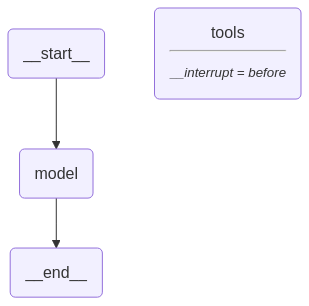

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Chennai?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_e44e)
 Call ID: call_e44e
  Args:
    query: Chennai weather today


In [18]:
snapshot = app.get_state(config=config)
snapshot.next

()

In [17]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_7wc9)
 Call ID: call_7wc9
  Args:
    query: Current weather in Chennai today
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in Chennai", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Chennai', 'region': 'Tamil Nadu', 'country': 'India', 'lat': 13.0833, 'lon': 80.2833, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1745755849, 'localtime': '2025-04-27 17:40'}, 'current': {'last_updated_epoch': 1745755200, 'last_updated': '2025-04-27 17:30', 'temp_c': 32.3, 'temp_f': 90.1, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 14.5, 'wind_kph': 23.4, 'wind_degree': 114, 'wind_dir': 'ESE', 'pressure_mb': 1006.0, 'pressure_in': 29.71, 'precip_mm': 0.0, 'precip_in': 0.0, 'h

In [21]:
snapshot = app.get_state(config=config)
snapshot.values

{'messages': [HumanMessage(content='What is the current weather in Chennai?', additional_kwargs={}, response_metadata={}, id='a7b09520-c5ae-4de4-ba2c-0ea43ebc4542'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mr9c', 'function': {'arguments': '{"query": "Chennai current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.028, 'prompt_time': 0.053241063, 'queue_time': 0.045200460000000005, 'total_time': 0.081241063}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-26a0c363-f8e1-47e3-b9be-03b8bae0508f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai current weather'}, 'id': 'call_mr9c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307}),
  ToolMessa